### Setup

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

### Data

In [3]:
x, y = 'image', 'label'
name='fashion_mnist'
dsd = load_dataset(name)
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)

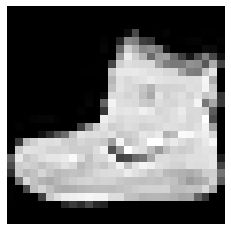

In [5]:
ds = tds['train']
img = ds[0]['image']
show_image(img)

In [6]:
cf = collate_dict(ds)

def collate_(b):
    return to_device(cf(b))

bs = 256

def data_loaders(dsd, bs, **kwargs):
    return {k:DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

dls = data_loaders(tds, bs, collate_fn=collate_)

In [7]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [8]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

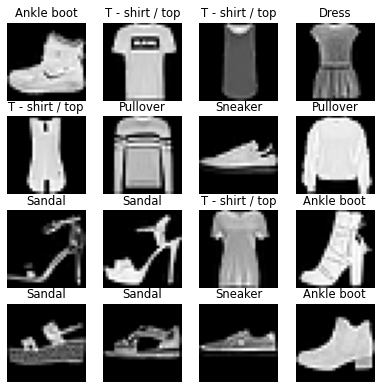

In [10]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

### Autoencoder

In [11]:
def deconv(ni, nf, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for i in range(epochs):

        model.train()
        for xb, _ in train_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            t_loss=0.0
            n=0
            for xb, _ in valid_dl:
                pred = model(xb)
                t_loss += loss_func(pred, xb)
                n+=1

        print(f'{i} {t_loss/n:.3f}')

In [13]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1,2),
    conv(2,4),
#    conv(4,8),
#    deconv(8, 4),
    deconv(4, 2),
    deconv(2, 1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()
).to(def_device)

In [14]:
from torch import optim

opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.030
1 0.027
2 0.025
3 0.024
4 0.024


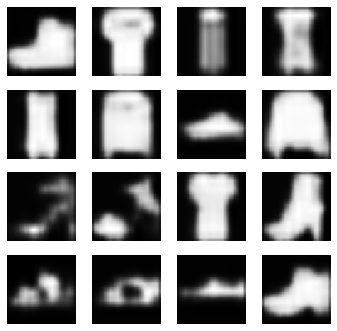

In [15]:
pred = ae(xb)
show_images(pred[:16].data.cpu(), imsize=1.5)

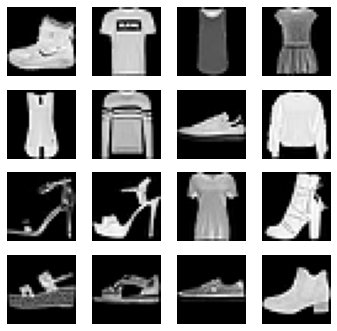

In [16]:
show_images(xb[:16].data.cpu(), imsize=1.5)